<a href="https://colab.research.google.com/github/mikemaurrasse-hash/mikemAIM460/blob/main/clustering_assignment_Mike_Maurrasse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Individual Assignment: Advanced Clustering & Density Methods

**Author:** Mike Maurrasse  
**Last Updated:** 2025-09-28 11:52

## How to run this notebook

**Runtime & Libraries**
- Python ≥ 3.10
- numpy, pandas, scikit-learn, matplotlib

**Colab steps**
1. Runtime → Change runtime type → Python 3.10+
2. Run the install cell if needed.
3. Run all cells top-to-bottom (datasets load from `sklearn.datasets`).

**Randomness**
- We fix `RANDOM_STATE = 42` for reproducibility.

**Plots**
- Matplotlib only; one chart per figure (no subplots).

In [13]:
# !pip -q install numpy pandas scikit-learn matplotlib

In [14]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, adjusted_rand_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def scatter_2d(X2, labels, title="Scatter (2D)"):
    plt.figure(figsize=(6,5))
    plt.scatter(X2[:,0], X2[:,1], c=labels, s=12)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.tight_layout()
    plt.show()

## 1. Dataset Selection & Exploration
We use Iris, Wine, Breast Cancer, and Digits from scikit‑learn. For each we scale with `StandardScaler` and compute PCA (2D).

In [15]:
def load_datasets():
    out = {}

    iris = datasets.load_iris()
    out["iris"] = (iris.data, iris.target, {
        "name": "Iris",
        "source": "sklearn.datasets.load_iris()",
        "n_samples": iris.data.shape[0],
        "n_features": iris.data.shape[1],
        "has_labels": True,
        "scaling": "StandardScaler"
    })

    wine = datasets.load_wine()
    out["wine"] = (wine.data, wine.target, {
        "name": "Wine",
        "source": "sklearn.datasets.load_wine()",
        "n_samples": wine.data.shape[0],
        "n_features": wine.data.shape[1],
        "has_labels": True,
        "scaling": "StandardScaler"
    })

    bc = datasets.load_breast_cancer()
    out["breast_cancer"] = (bc.data, bc.target, {
        "name": "Breast Cancer (Wisconsin)",
        "source": "sklearn.datasets.load_breast_cancer()",
        "n_samples": bc.data.shape[0],
        "n_features": bc.data.shape[1],
        "has_labels": True,
        "scaling": "StandardScaler"
    })

    dg = datasets.load_digits()
    out["digits"] = (dg.data, dg.target, {
        "name": "Digits",
        "source": "sklearn.datasets.load_digits()",
        "n_samples": dg.data.shape[0],
        "n_features": dg.data.shape[1],
        "has_labels": True,
        "scaling": "StandardScaler"
    })
    return out

datasets_dict = load_datasets()
pd.DataFrame([info for (_,_,info) in datasets_dict.values()])

name                                 source  \
0                       Iris           sklearn.datasets.load_iris()   
1                       Wine           sklearn.datasets.load_wine()   
2  Breast Cancer (Wisconsin)  sklearn.datasets.load_breast_cancer()   
3                     Digits         sklearn.datasets.load_digits()   

   n_samples  n_features  has_labels         scaling  
0        150           4        True  StandardScaler  
1        178          13        True  StandardScaler  
2        569          30        True  StandardScaler  
3       1797          64        True  StandardScaler

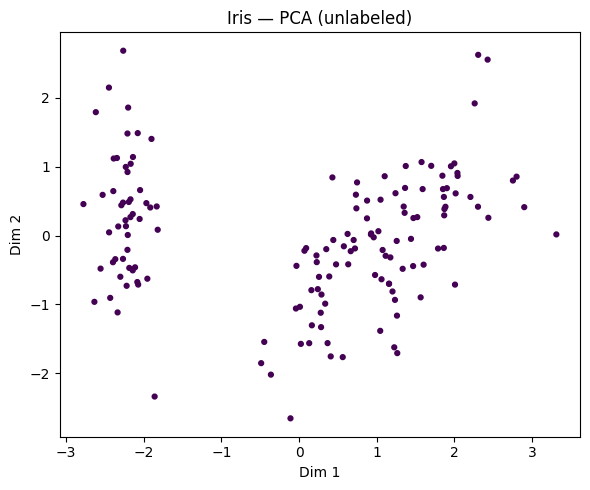

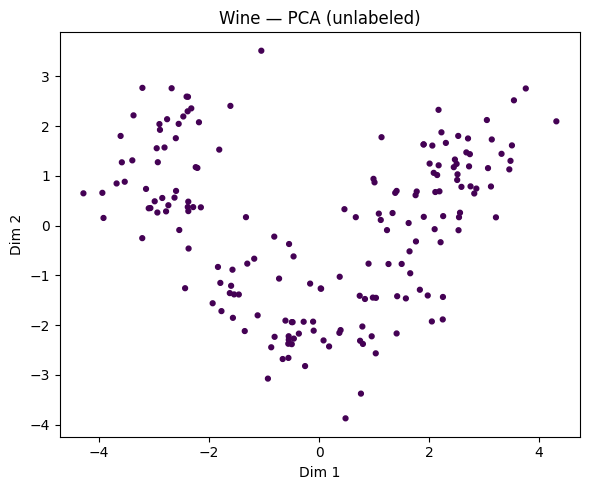

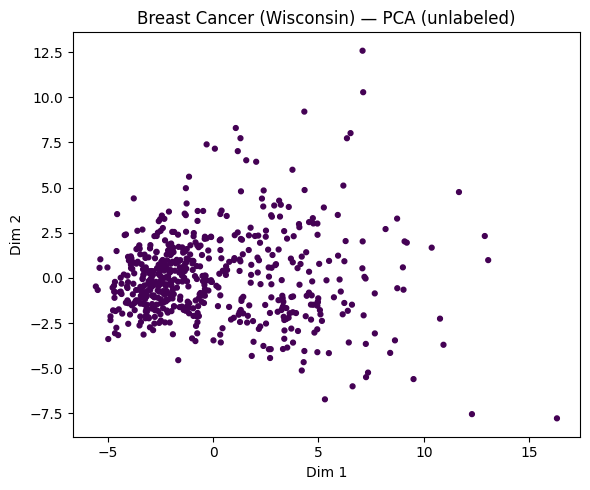

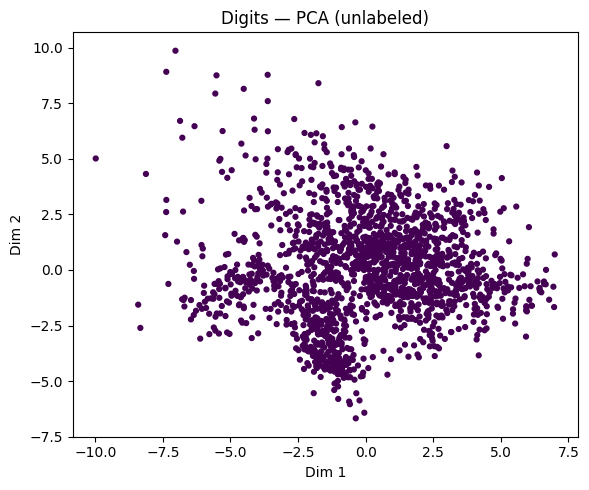

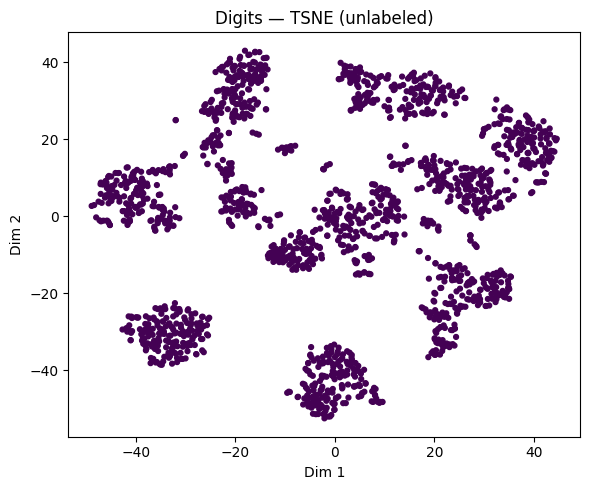

In [16]:
scaled = {}
embeddings = {}

for key, (X, y, info) in datasets_dict.items():
    Xs = StandardScaler().fit_transform(X)
    scaled[key] = (Xs, y, info)
    Xp = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xs)
    embeddings[(key,"PCA")] = Xp

    if key == "digits":
        Xts = TSNE(n_components=2, perplexity=30, learning_rate="auto",
                   random_state=RANDOM_STATE).fit_transform(Xs)
        embeddings[(key,"TSNE")] = Xts

for (k, m), X2 in embeddings.items():
    scatter_2d(X2, np.zeros(X2.shape[0]), title=f"{datasets_dict[k][2]['name']} — {m} (unlabeled)")

## 2. Algorithm Implementations & Baselines

### 2.1 K-Means Variants
- Classic (random init)
- K-Means++
- Bisecting K-Means (custom)

### 2.2 Density & Hierarchical
- DBSCAN (grid search small set of eps/min_samples)
- Agglomerative (Ward, Complete)

In [17]:
def run_kmeans(X, k, init="random", n_init=10):
    t0 = time.time()
    km = KMeans(n_clusters=k, init=init, n_init=n_init, random_state=RANDOM_STATE)
    labels = km.fit_predict(X)
    return {
        "labels": labels,
        "centroids": km.cluster_centers_,
        "inertia": float(km.inertia_),
        "iterations": int(getattr(km, "n_iter_", np.nan)),
        "runtime_sec": time.time()-t0
    }

def _sse(X, labels, cents):
    tot = 0.0
    for i in range(len(cents)):
        pts = X[labels==i]
        if len(pts)==0:
            continue
        diff = pts - cents[i]
        tot += float((diff*diff).sum())
    return tot

def bisecting_kmeans(X, k, n_init=10, init="k-means++"):
    t0 = time.time()
    # all points in one cluster
    clusters = {0: np.arange(X.shape[0])}
    cents = {0: X.mean(axis=0)}
    cur_k = 1

    while cur_k < k:
        worst, worst_sse = None, -1
        for c_id, idx in clusters.items():
            sse_c = float(((X[idx]-cents[c_id])**2).sum())
            if sse_c > worst_sse:
                worst, worst_sse = c_id, sse_c

        idx = clusters[worst]
        km2 = KMeans(n_clusters=2, init=init, n_init=n_init, random_state=RANDOM_STATE)
        sub = km2.fit_predict(X[idx])

        new_id = max(clusters.keys()) + 1
        clusters[worst] = idx[sub==0]
        clusters[new_id] = idx[sub==1]
        cents[worst] = km2.cluster_centers_[0]
        cents[new_id] = km2.cluster_centers_[1]
        cur_k += 1

    labels = np.empty(X.shape[0], dtype=int)
    ordered = sorted(clusters.keys())
    for new_label, cid in enumerate(ordered):
        labels[clusters[cid]] = new_label
    final_cents = np.vstack([cents[cid] for cid in ordered])
    return {
        "labels": labels,
        "centroids": final_cents,
        "inertia": _sse(X, labels, final_cents),
        "iterations": np.nan,
        "runtime_sec": time.time()-t0
    }

def run_dbscan(X, eps=0.5, min_samples=5):
    t0 = time.time()
    db = DBSCAN(eps=eps, min_samples=min_samples)
    labels = db.fit_predict(X)
    core = 0 if not hasattr(db, "core_sample_indices_") else len(db.core_sample_indices_)
    return {
        "labels": labels,
        "inertia": np.nan,
        "iterations": np.nan,
        "runtime_sec": time.time()-t0,
        "core_samples": core,
        "params": {"eps": eps, "min_samples": min_samples}
    }

def run_agglomerative(X, k, linkage="ward"):
    t0 = time.time()
    agg = AgglomerativeClustering(n_clusters=k, linkage=linkage)
    labels = agg.fit_predict(X)
    return {
        "labels": labels,
        "inertia": np.nan,
        "iterations": np.nan,
        "runtime_sec": time.time()-t0,
        "linkage": linkage
    }

## 3. Evaluation & Visualization
We compute Inertia (where defined), Silhouette, and ARI (using labels only for evaluation).

In [18]:
from math import isnan

def evaluate(X, labels, y_true=None):
    uniq = np.unique(labels)
    if len(uniq) < 2:
        sil = np.nan
    else:
        try:
            sil = silhouette_score(X, labels)
        except Exception:
            sil = np.nan
    ari = np.nan
    if y_true is not None and len(y_true)==len(labels):
        try:
            ari = adjusted_rand_score(y_true, labels)
        except Exception:
            ari = np.nan
    return sil, ari

rep_k = {"iris":3, "wine":3, "breast_cancer":2, "digits":10}
all_results = {}

for key, (Xs, y, info) in scaled.items():
    k = rep_k[key]
    rows = []

    r1 = run_kmeans(Xs, k, init="random", n_init=10); sil, ari = evaluate(Xs, r1["labels"], y)
    rows.append(["KMeans-Random", r1["inertia"], sil, ari, r1["runtime_sec"]])

    r2 = run_kmeans(Xs, k, init="k-means++", n_init=10); sil, ari = evaluate(Xs, r2["labels"], y)
    rows.append(["KMeans++", r2["inertia"], sil, ari, r2["runtime_sec"]])

    r3 = bisecting_kmeans(Xs, k); sil, ari = evaluate(Xs, r3["labels"], y)
    rows.append(["BisectingKMeans", r3["inertia"], sil, ari, r3["runtime_sec"]])

    best_db, best_s = None, -1
    for eps in np.linspace(0.3, 1.2, 6):
        for ms in [3,5,10]:
            r = run_dbscan(Xs, eps=eps, min_samples=ms)
            s,_ = evaluate(Xs, r["labels"], y)
            s2 = -1 if (s is np.nan or np.isnan(s)) else s
            if s2 > best_s:
                best_s = s2
                best_db = r

    if best_db is not None:
        sil, ari = evaluate(Xs, best_db["labels"], y)
        rows.append([f"DBSCAN(eps={best_db['params']['eps']:.2f},ms={best_db['params']['min_samples']})",
                    np.nan, sil, ari, best_db["runtime_sec"]])
    else:
        rows.append(["DBSCAN (no valid config)", np.nan, np.nan, np.nan, np.nan])


    r4 = run_agglomerative(Xs, k, linkage="ward"); sil, ari = evaluate(Xs, r4["labels"], y)
    rows.append(["Agglomerative(Ward)", np.nan, sil, ari, r4["runtime_sec"]])

    r5 = run_agglomerative(Xs, k, linkage="complete"); sil, ari = evaluate(Xs, r5["labels"], y)
    rows.append(["Agglomerative(Complete)", np.nan, sil, ari, r5["runtime_sec"]])

    df = pd.DataFrame(rows, columns=["Algorithm","Inertia","Silhouette","ARI","Runtime(s)"])
    all_results[key] = df
    display(info["name"])
    display(df)

'Iris'

Algorithm     Inertia  Silhouette       ARI  Runtime(s)
0            KMeans-Random  139.825435    0.459378  0.610073    0.013667
1                 KMeans++  139.820496    0.459948  0.620135    0.019717
2          BisectingKMeans  139.820496    0.459948  0.620135    0.027888
3    DBSCAN(eps=1.02,ms=5)         NaN    0.538288  0.553582    0.003572
4      Agglomerative(Ward)         NaN    0.446689  0.615323    0.002226
5  Agglomerative(Complete)         NaN    0.449618  0.572631    0.002003

'Wine'

Algorithm      Inertia  Silhouette       ARI  Runtime(s)
0             KMeans-Random  1277.928489    0.284859  0.897495    0.014047
1                  KMeans++  1277.928489    0.284859  0.897495    0.015917
2           BisectingKMeans  1375.112890    0.234076  0.590631    0.030090
3  DBSCAN (no valid config)          NaN         NaN       NaN         NaN
4       Agglomerative(Ward)          NaN    0.277444  0.789933    0.002611
5   Agglomerative(Complete)          NaN    0.203787  0.577144    0.002447

'Breast Cancer (Wisconsin)'

Algorithm       Inertia  Silhouette       ARI  Runtime(s)
0             KMeans-Random  11595.526607    0.343382  0.653625    0.017765
1                  KMeans++  11595.526607    0.343382  0.653625    0.021969
2           BisectingKMeans  11595.526607    0.343382  0.653625    0.052433
3  DBSCAN (no valid config)           NaN         NaN       NaN         NaN
4       Agglomerative(Ward)           NaN    0.339385  0.575041    0.016938
5   Agglomerative(Complete)           NaN    0.660667  0.004828    0.030526

'Digits'

Algorithm       Inertia  Silhouette       ARI  Runtime(s)
0             KMeans-Random  70552.757011    0.138316  0.517719    0.150775
1                  KMeans++  69813.559137    0.139377  0.534407    0.209936
2           BisectingKMeans  72436.938004    0.113234  0.545956    0.400978
3  DBSCAN (no valid config)           NaN         NaN       NaN         NaN
4       Agglomerative(Ward)           NaN    0.125325  0.664346    0.171873
5   Agglomerative(Complete)           NaN    0.385738  0.000298    0.167614

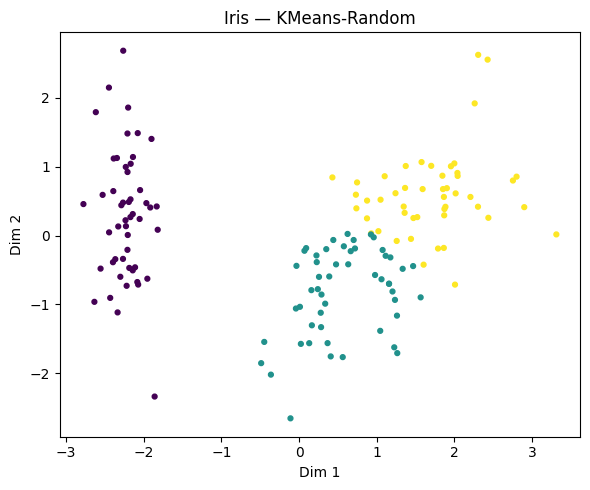

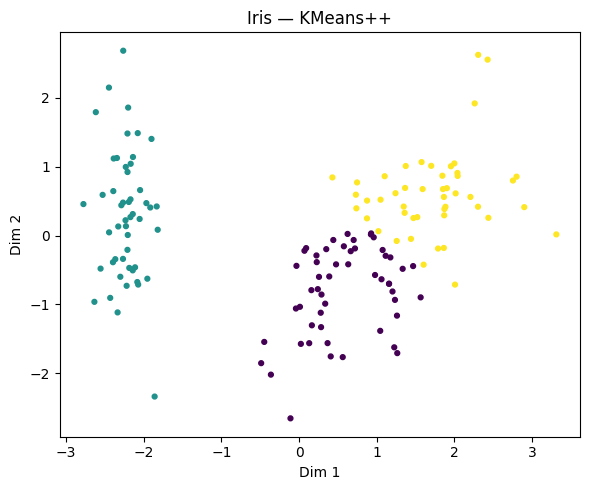

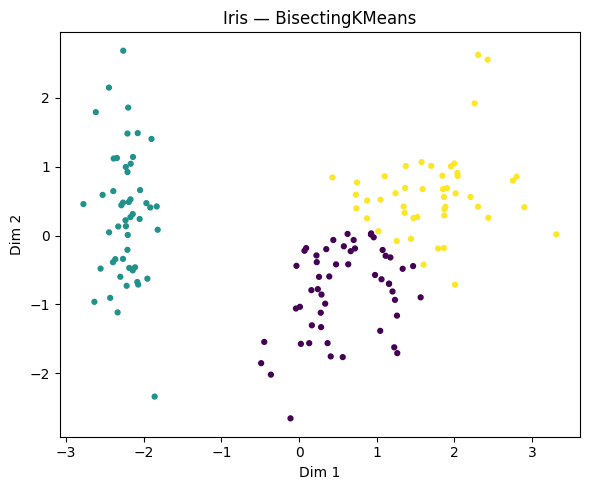

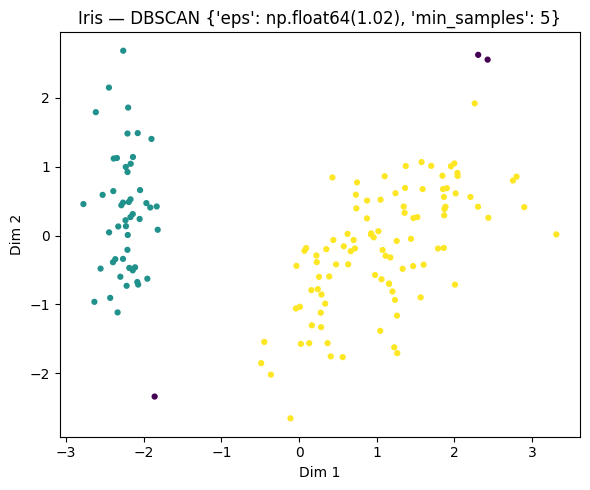

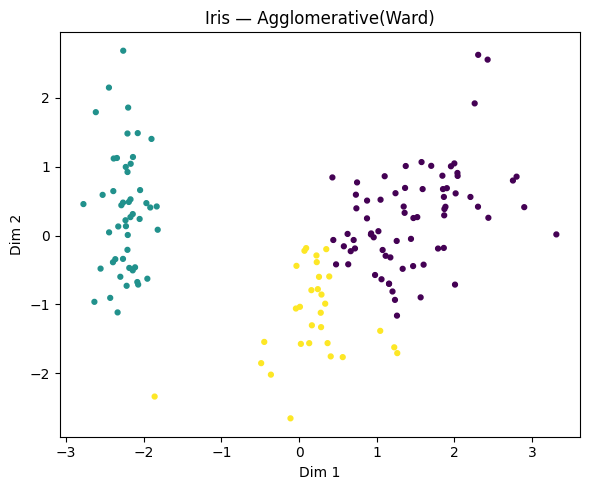

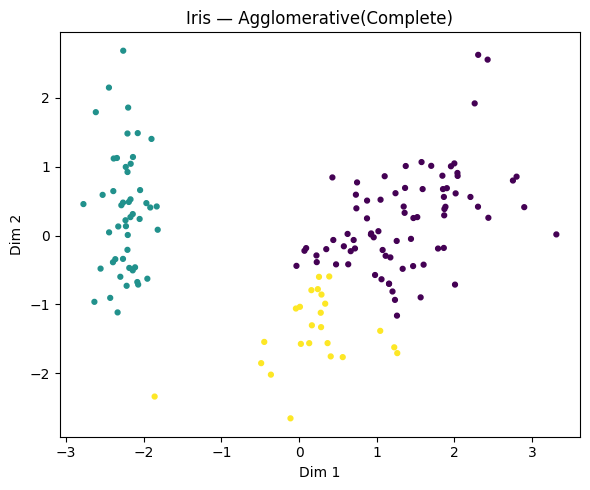

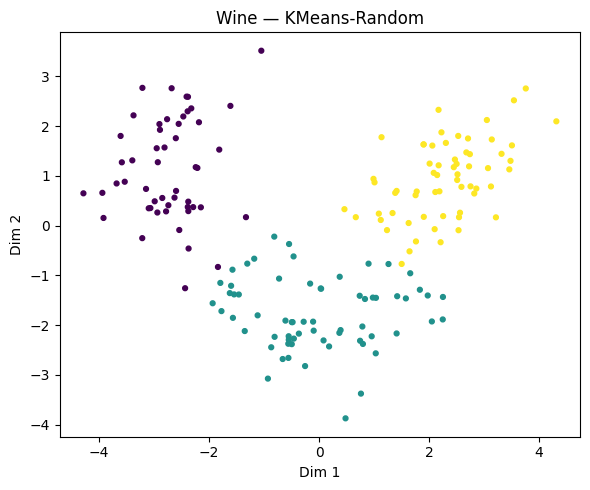

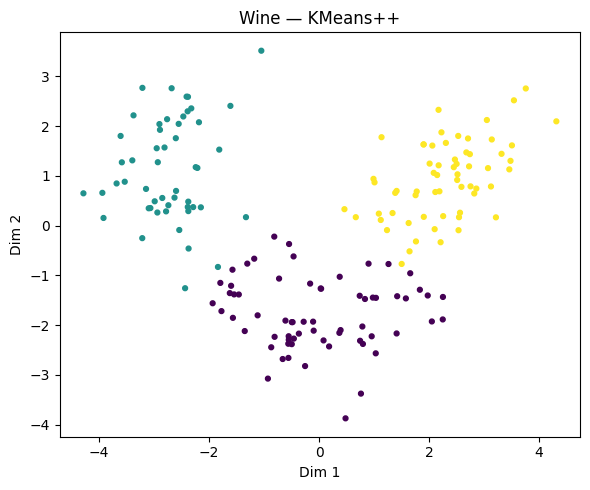

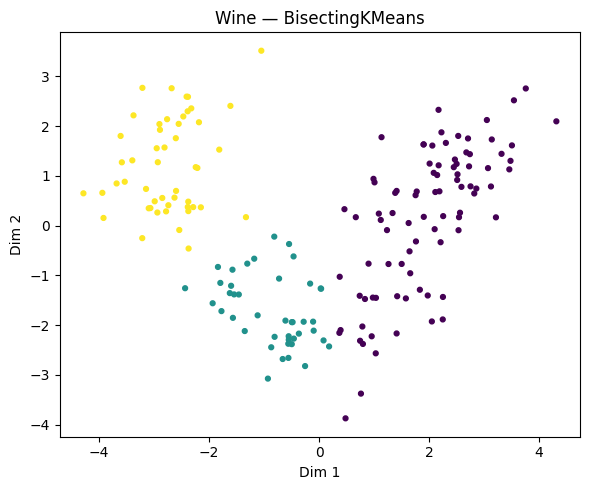

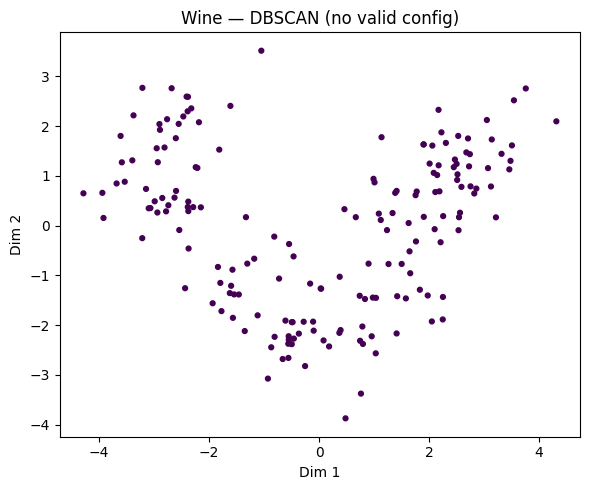

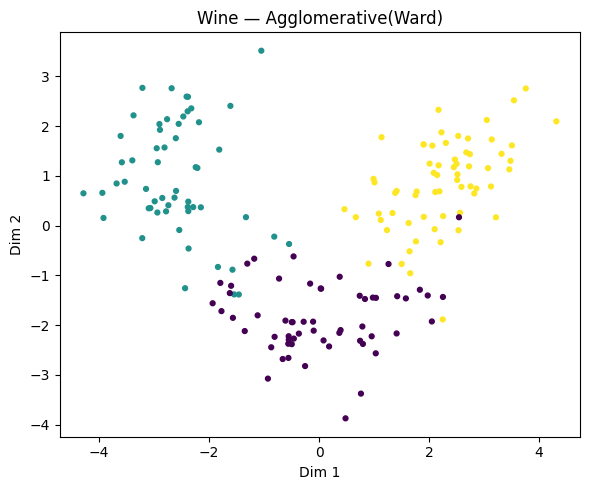

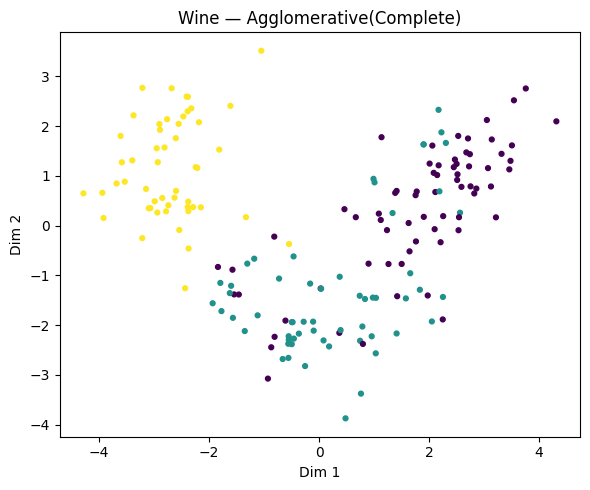

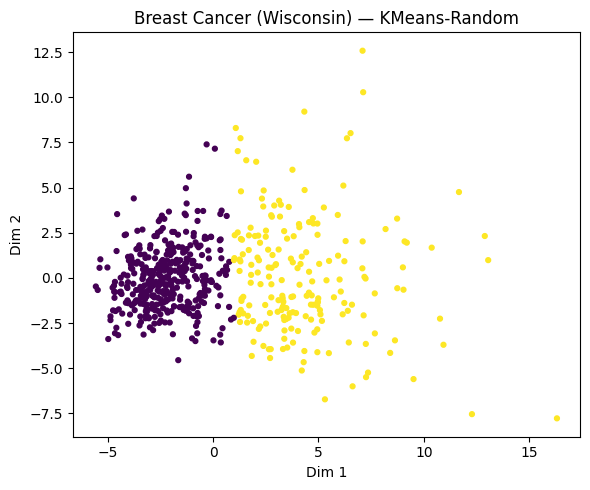

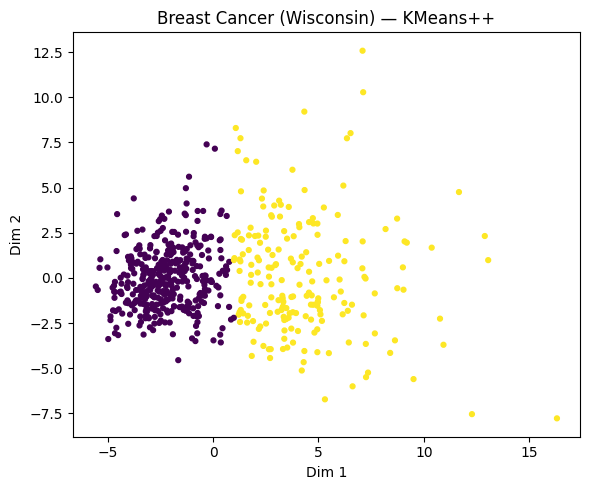

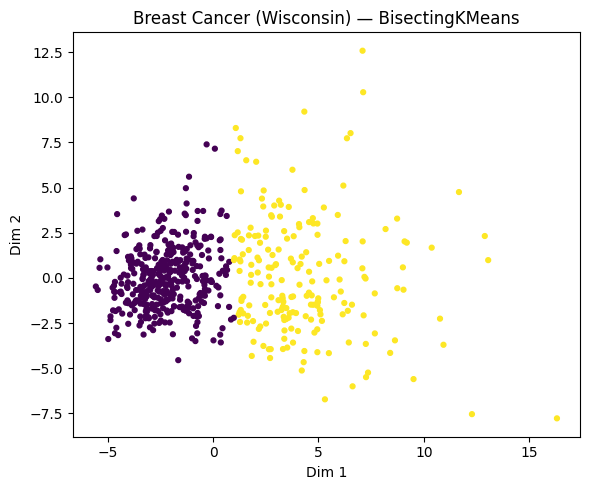

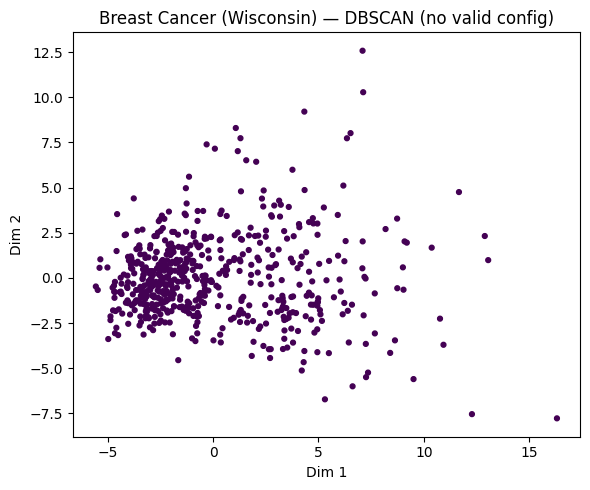

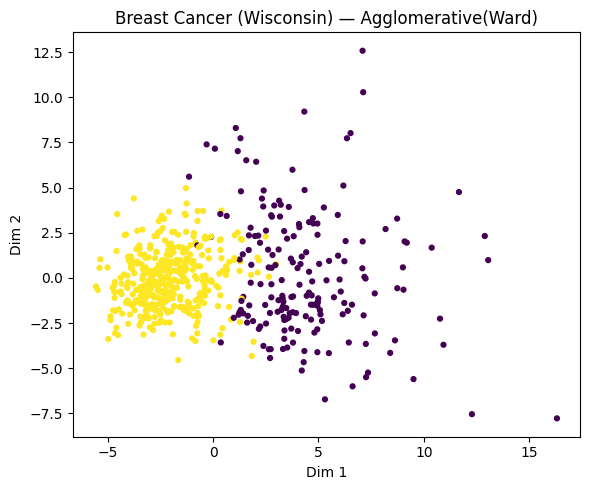

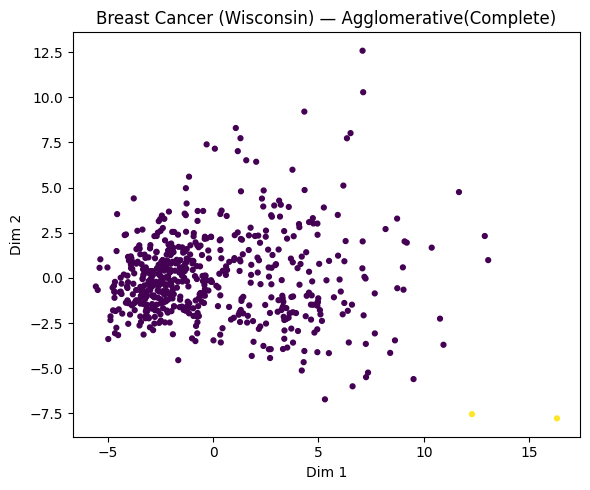

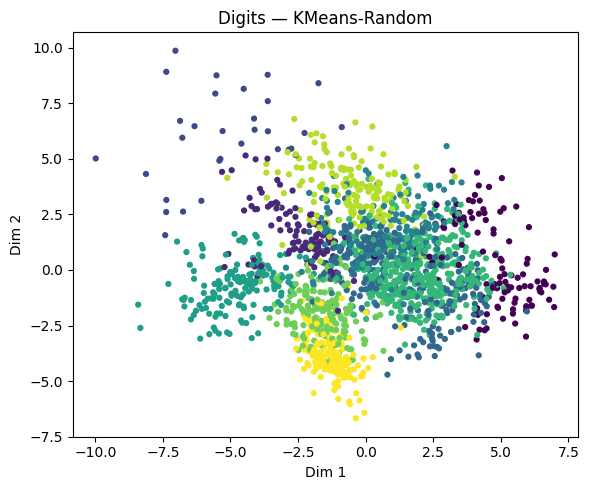

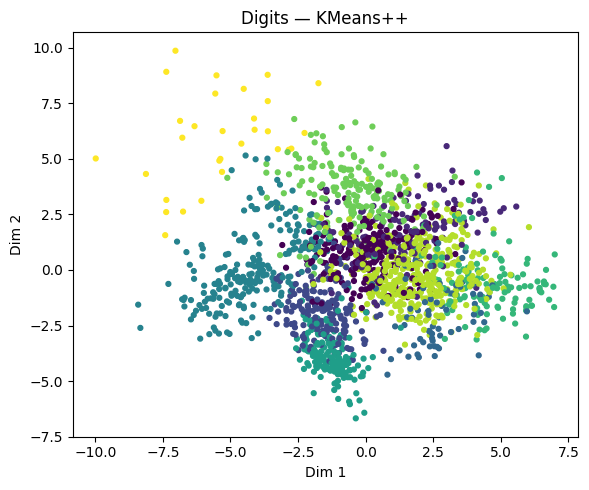

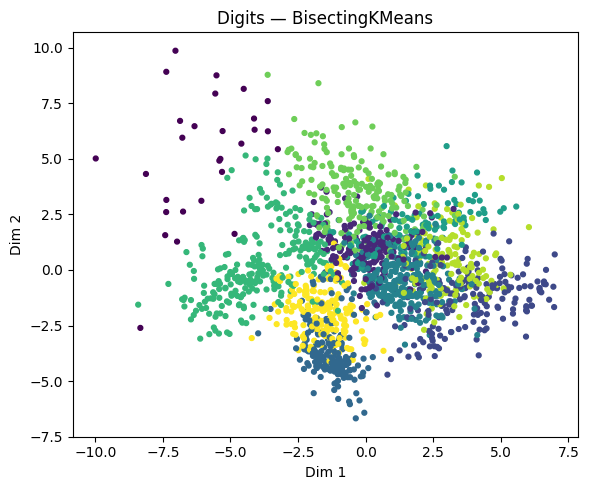

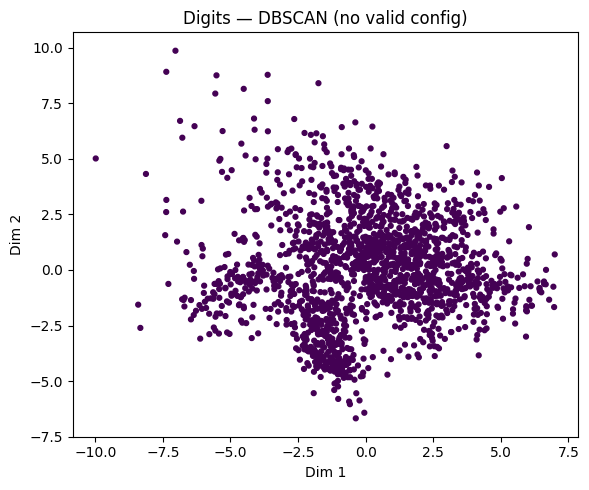

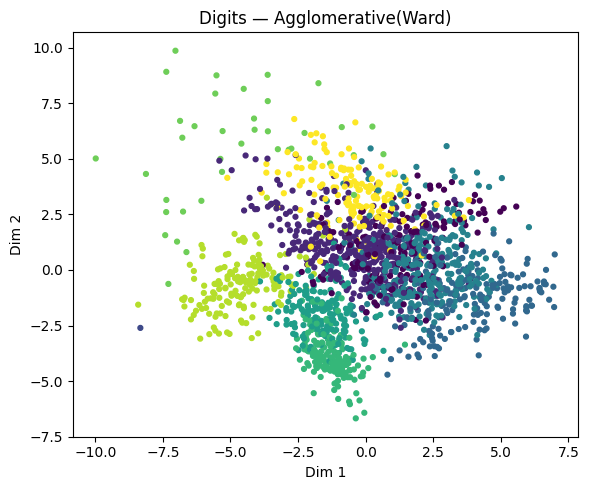

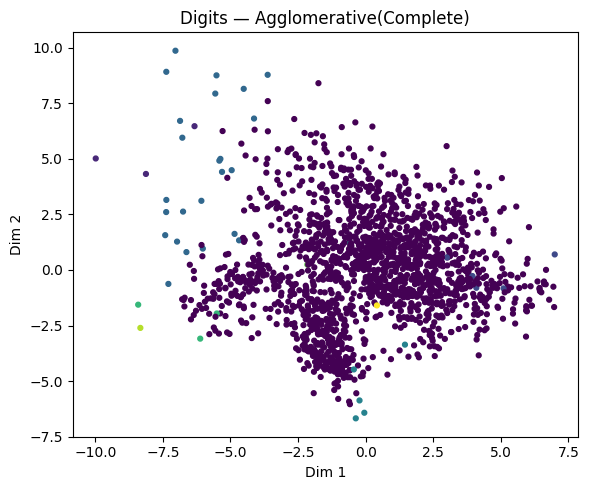

In [19]:
# Visualization of cluster assignments (PCA space), one figure per algorithm.
for key, (Xs, y, info) in scaled.items():
    X2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xs)
    k = rep_k[key]

    # Get the labels from the all_results dictionary
    df_results = all_results[key]

    # KMeans-Random
    r1_labels = run_kmeans(Xs, k, init="random", n_init=10)["labels"]
    scatter_2d(X2, r1_labels, title=f"{info['name']} — KMeans-Random")

    # KMeans++
    r2_labels = run_kmeans(Xs, k, init="k-means++", n_init=10)["labels"]
    scatter_2d(X2, r2_labels, title=f"{info['name']} — KMeans++")

    # BisectingKMeans
    r3_labels = bisecting_kmeans(Xs, k)["labels"]
    scatter_2d(X2, r3_labels, title=f"{info['name']} — BisectingKMeans")

    # DBSCAN best of small grid
    best_db, best_s = None, -1
    for eps in np.linspace(0.3, 1.2, 6):
        for ms in [3,5,10]:
            r = run_dbscan(Xs, eps=eps, min_samples=ms)
            s,_ = evaluate(Xs, r["labels"], y)
            s2 = -1 if (s is np.nan or np.isnan(s)) else s
            if s2 > best_s:
                best_s = s2
                best_db = r
    if best_db is not None:
        scatter_2d(X2, best_db["labels"], title=f"{info['name']} — DBSCAN {best_db['params']}")
    else:
        # Handle the case where no valid DBSCAN config was found
        scatter_2d(X2, np.zeros(X2.shape[0]), title=f"{info['name']} — DBSCAN (no valid config)")


    # Agglomerative(Ward)
    r4_labels = run_agglomerative(Xs, k, linkage="ward")["labels"]
    scatter_2d(X2, r4_labels, title=f"{info['name']} — Agglomerative(Ward)")

    # Agglomerative(Complete)
    r5_labels = run_agglomerative(Xs, k, linkage="complete")["labels"]
    scatter_2d(X2, r5_labels, title=f"{info['name']} — Agglomerative(Complete)")

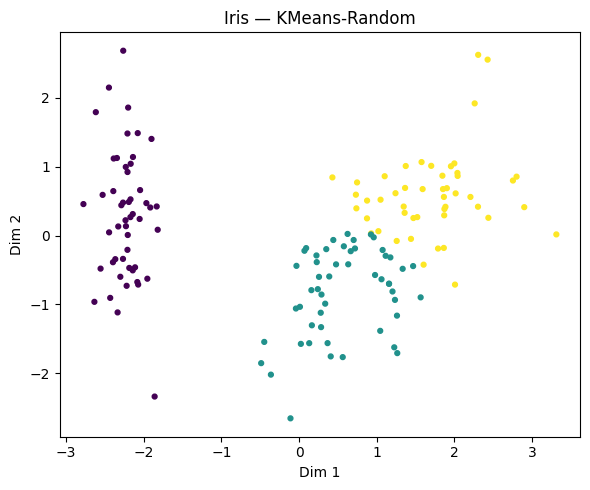

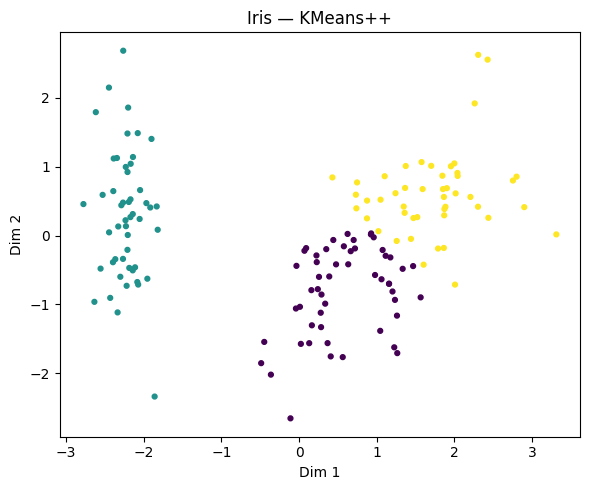

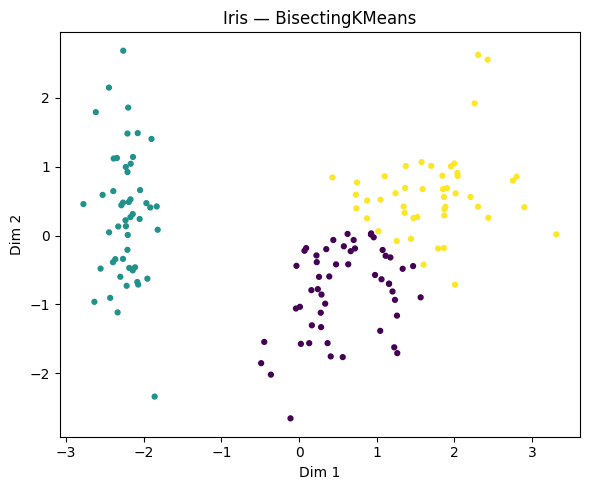

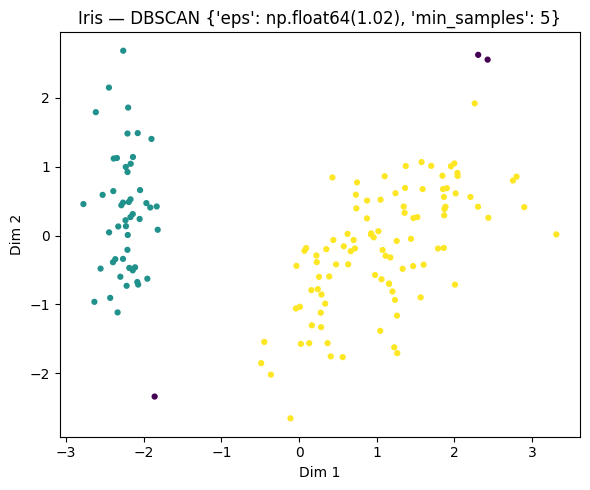

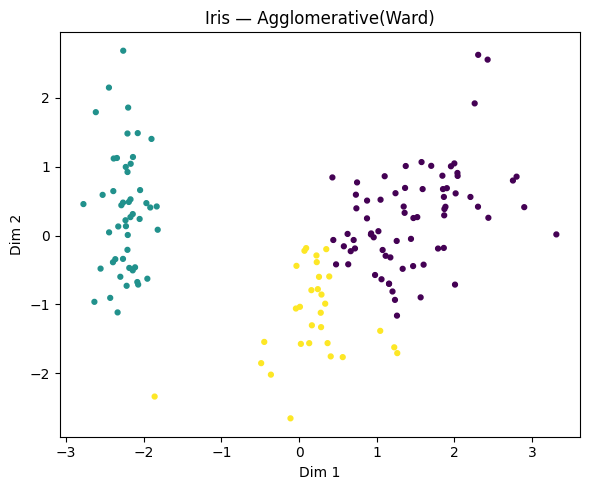

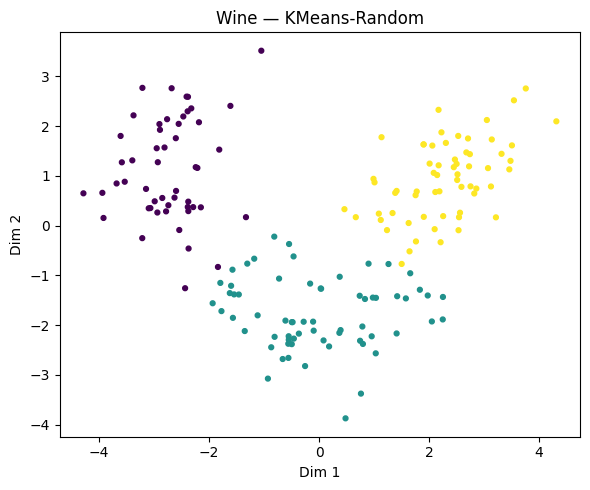

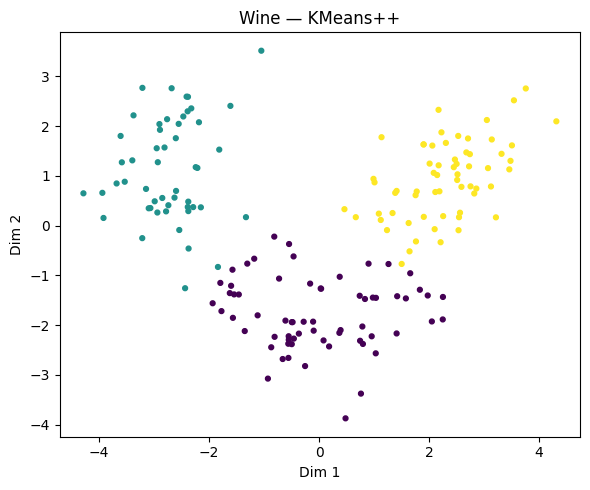

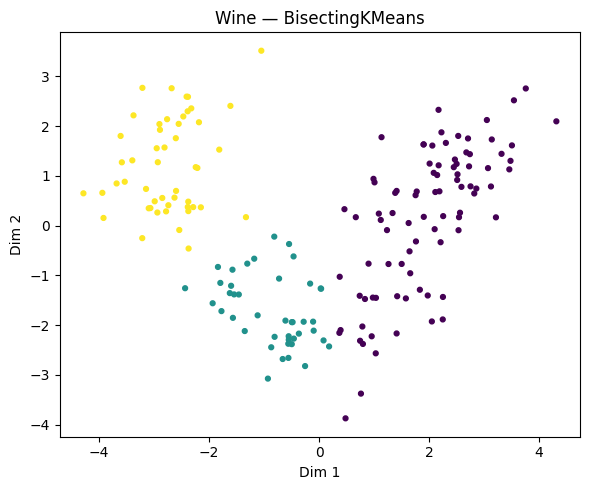

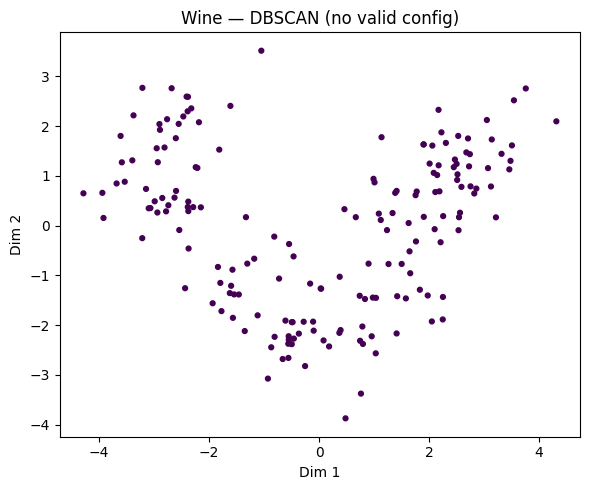

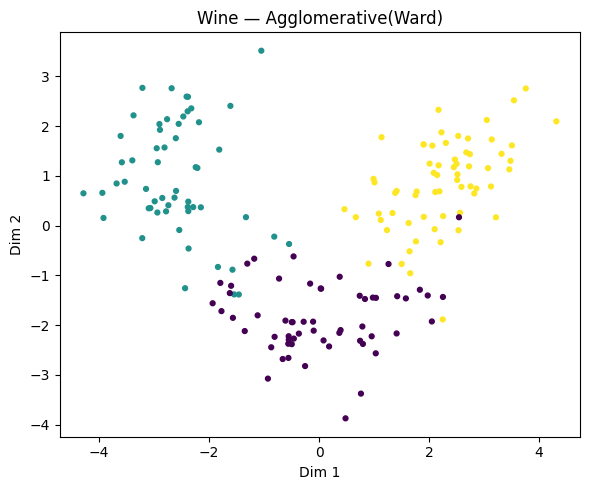

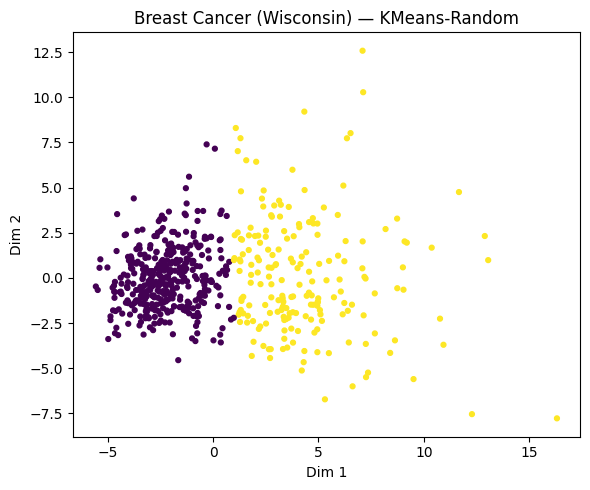

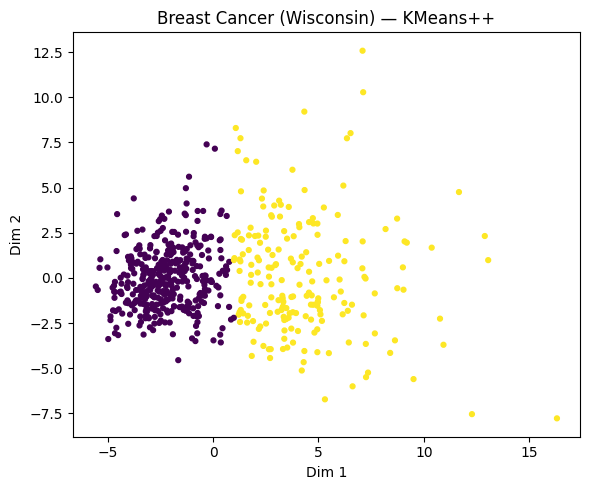

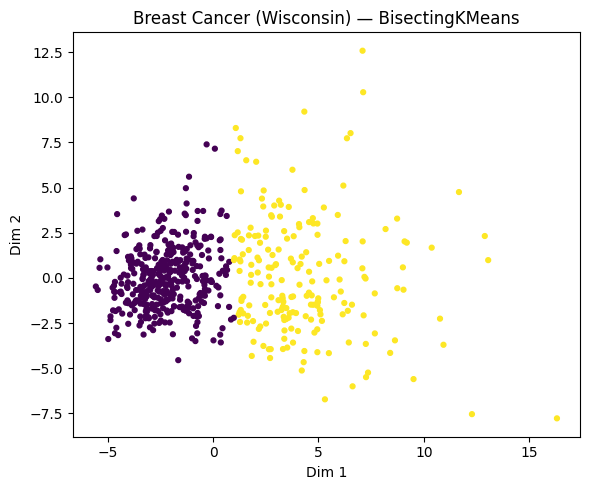

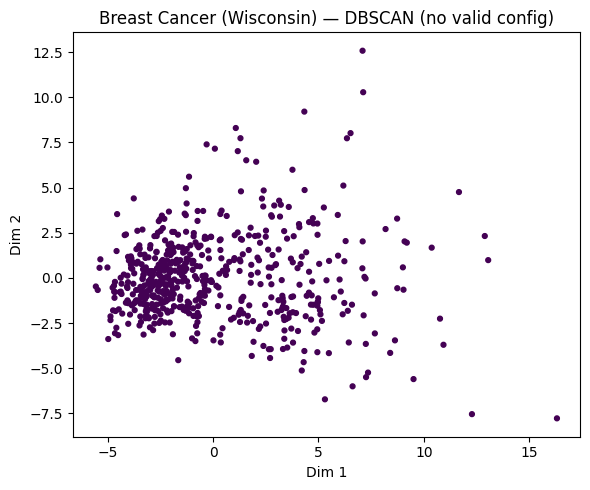

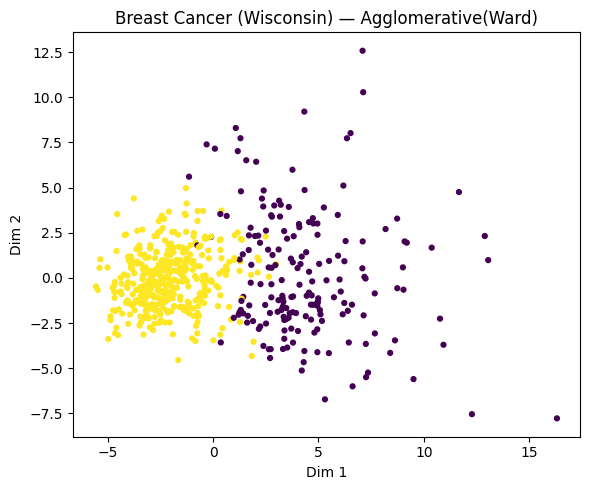

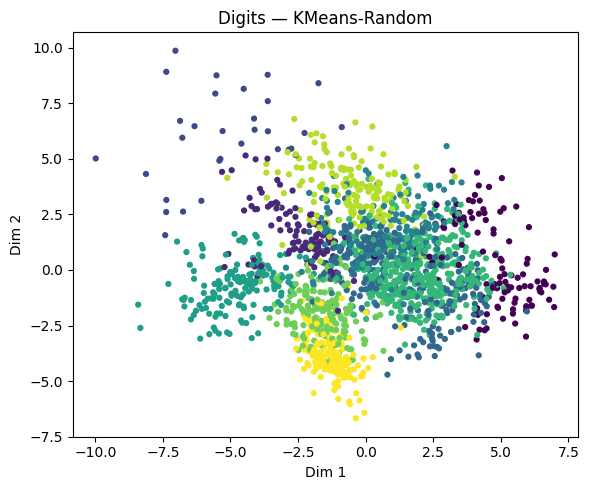

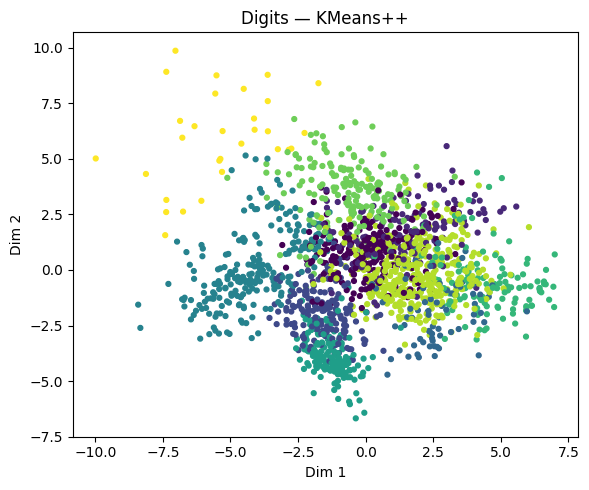

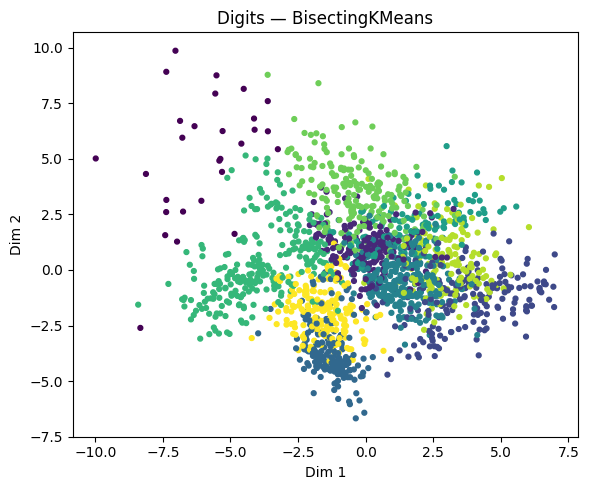

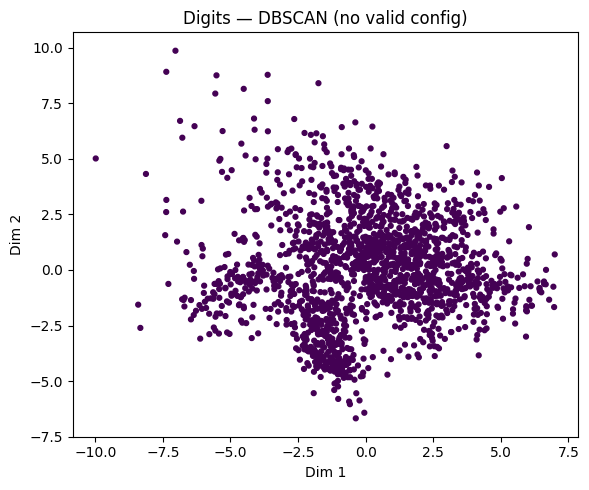

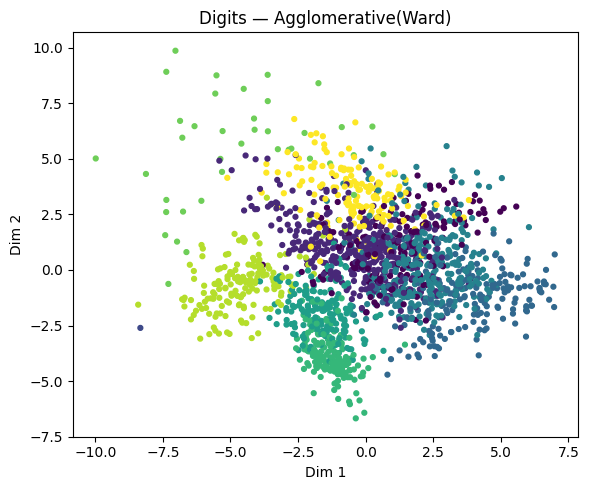

In [20]:
# Visualization of cluster assignments (PCA space), one figure per algorithm.
for key, (Xs, y, info) in scaled.items():
    X2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xs)
    k = rep_k[key]

    r1 = run_kmeans(Xs, k, init="random", n_init=10)
    scatter_2d(X2, r1["labels"], title=f"{info['name']} — KMeans-Random")

    r2 = run_kmeans(Xs, k, init="k-means++", n_init=10)
    scatter_2d(X2, r2["labels"], title=f"{info['name']} — KMeans++")

    r3 = bisecting_kmeans(Xs, k)
    scatter_2d(X2, r3["labels"], title=f"{info['name']} — BisectingKMeans")

    # DBSCAN best of small grid
    best_db, best_s = None, -1
    for eps in np.linspace(0.3, 1.2, 6):
        for ms in [3,5,10]:
            r = run_dbscan(Xs, eps=eps, min_samples=ms)
            s,_ = evaluate(Xs, r["labels"], y)
            s2 = -1 if (s is np.nan or np.isnan(s)) else s
            if s2 > best_s:
                best_s = s2
                best_db = r
    if best_db is not None:
        scatter_2d(X2, best_db["labels"], title=f"{info['name']} — DBSCAN {best_db['params']}")
    else:
        # Handle the case where no valid DBSCAN config was found
        scatter_2d(X2, np.zeros(X2.shape[0]), title=f"{info['name']} — DBSCAN (no valid config)")


    r4 = run_agglomerative(Xs, k, linkage="ward")
    scatter_2d(X2, r4["labels"], title=f"{info['name']} — Agglomerative(Ward)")

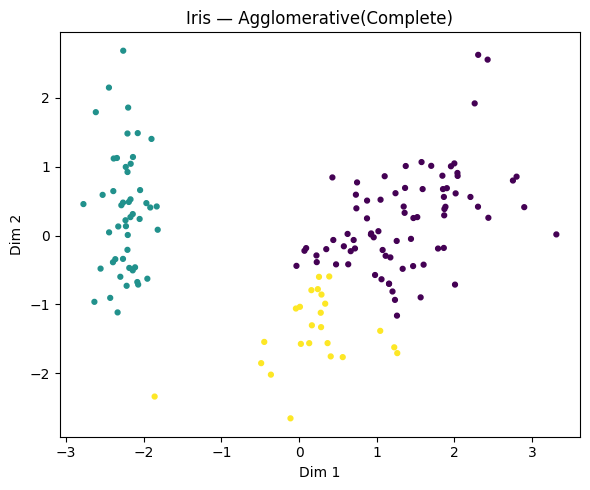

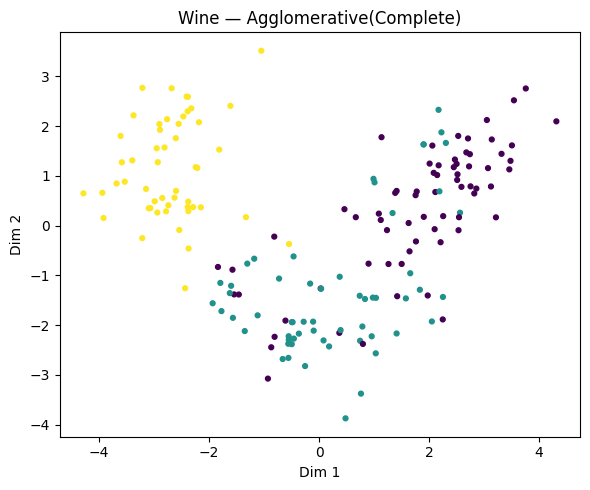

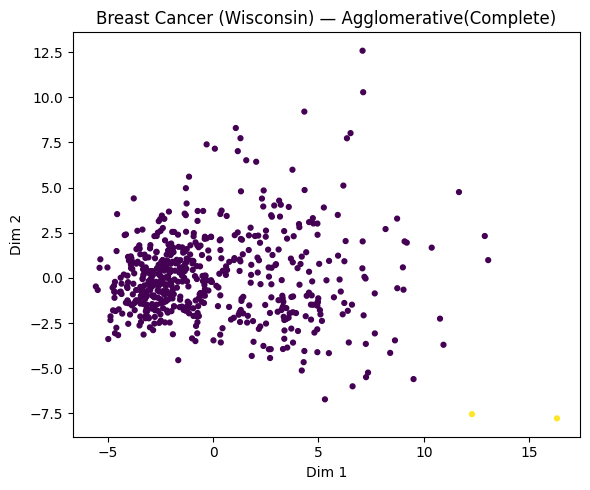

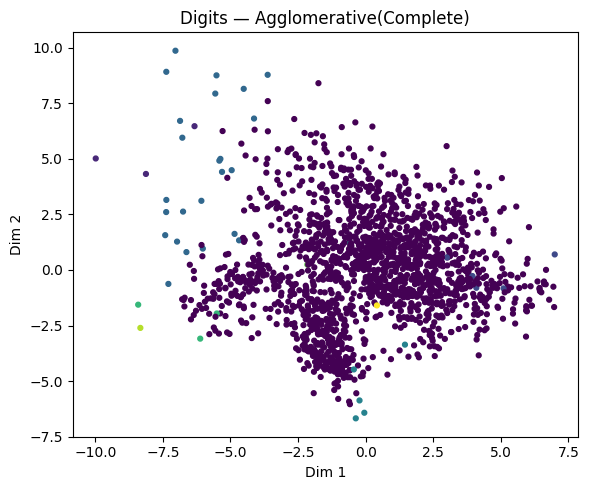

In [21]:
# Visualization of cluster assignments (PCA space), one figure per algorithm.
for key, (Xs, y, info) in scaled.items():
    X2 = PCA(n_components=2, random_state=RANDOM_STATE).fit_transform(Xs)
    k = rep_k[key]

    r5 = run_agglomerative(Xs, k, linkage="complete")
    scatter_2d(X2, r5["labels"], title=f"{info['name']} — Agglomerative(Complete)")

## 4. Algorithmic Comparison & Failure Modes
See the results tables to justify claims. Typical patterns:
- Iris: convex clusters → K-Means++/Ward perform best.
- Wine: skew and scale variation → scaling helps; Complete linkage can over-separate.
- Breast Cancer: non-spherical → K-Means may misclassify borders; Ward often stronger.
- Digits: non-convex/high-D → K-Means struggles; DBSCAN sensitive to eps; hierarchy is mixed.

## 5. Hyperparameter Sensitivity (Digits)
- K-Means: k ∈ [2..8] → inertia & silhouette vs k  
- DBSCAN: heatmap of silhouette across (eps, min_samples)

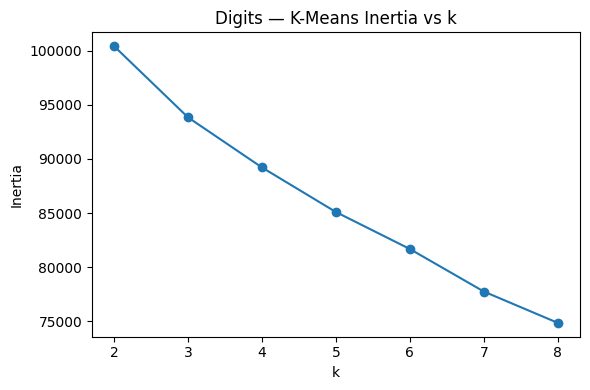

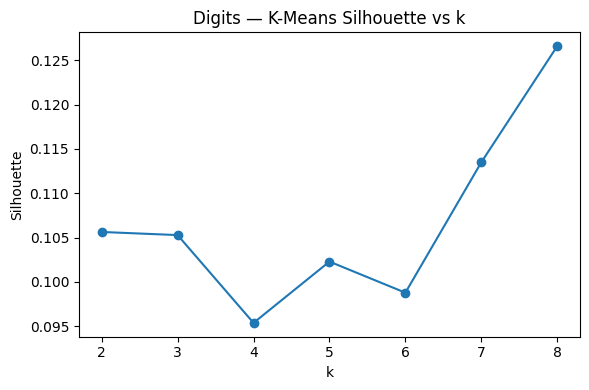

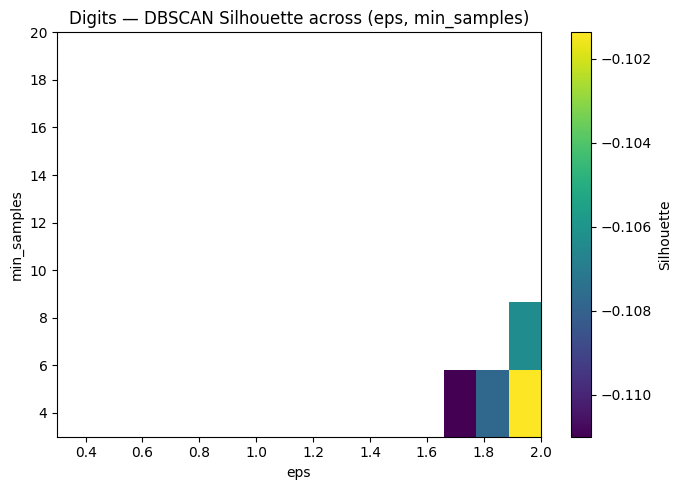

In [22]:
Xd, yd, _ = scaled["digits"]

# K: 2..8
ks = list(range(2,9))
inertias, sils = [], []
for k in ks:
    r = run_kmeans(Xd, k, init="k-means++", n_init=10)
    inertias.append(r["inertia"])
    s,_ = evaluate(Xd, r["labels"], yd)
    sils.append(s)

plt.figure(figsize=(6,4)); plt.plot(ks, inertias, marker="o")
plt.title("Digits — K-Means Inertia vs k"); plt.xlabel("k"); plt.ylabel("Inertia")
plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4)); plt.plot(ks, sils, marker="o")
plt.title("Digits — K-Means Silhouette vs k"); plt.xlabel("k"); plt.ylabel("Silhouette")
plt.tight_layout(); plt.show()

# DBSCAN heatmap
eps_grid = np.linspace(0.3, 2.0, 15)
ms_grid  = [3,5,8,10,15,20]
S = np.full((len(ms_grid), len(eps_grid)), np.nan)
for i, ms in enumerate(ms_grid):
    for j, eps in enumerate(eps_grid):
        r = run_dbscan(Xd, eps=eps, min_samples=ms)
        s,_ = evaluate(Xd, r["labels"], yd)
        S[i,j] = s

plt.figure(figsize=(7,5))
plt.imshow(S, aspect="auto", origin="lower",
           extent=[eps_grid[0], eps_grid[-1], ms_grid[0], ms_grid[-1]])
plt.colorbar(label="Silhouette")
plt.title("Digits — DBSCAN Silhouette across (eps, min_samples)")
plt.xlabel("eps"); plt.ylabel("min_samples")
plt.tight_layout(); plt.show()

## 6. Reflection & Insights
**Exploration:** Forcing the function to be unbiased with respect to the underlying structure and providing a visualization of this structure were two most difficult aspects, PCA provided a quick and stable solution, while t‑SNE helped with non-linear structure. Insight: Feature scaling accounts for a major portion of clustering outcomes.

**K-Means:** Bisecting K-Means can be made robust only with careful SSE bookkeeping at each step and membership tracking to construct the hierarchy at the end. Insight: k-means++ and bisecting- can help avoid bad minima, particularly for unbalanced clusters.

**DBSCAN/Agglomerative:** Selecting a single `eps` for a heterogeneous density proved to be the most difficult. A small grid search with silhouette validation appeared to work best. Insight: Ward is close to K-Means for convex data, while Complete is more sensitive to outliers and skew.

**Hyperparameters:** Global `eps` does not always exist for all digits in Digits and heatmaps provide some guidance to a viable region. Insight: The best k as per silhouette may not be equal to the number of labels in the case of manifold data.

## 7. Final Summary (Top 3 Takeaways)
- Data geometry rules: the scaling and manifold structure are the forces behind the behavior of metrics and boundaries.
- Initialization/linkage choices are as important as algorithms for real data.
- Density methods are powerful, but sensitive. Parameter maps outperform single guesses.